# Scrublet

Testing out the python package [scrublet](https://github.com/AllonKleinLab/scrublet) for ID of doublets.

In [50]:
import numpy as np
import pandas as pd
import scrublet as scr
from larval_gonad.io import cellranger_counts

In [123]:
multi_rate = {
    'rep1': {
        'n_cells': 6_000,
        'pct_multi': 0.023,
    },
    'rep2': {
        'n_cells': 6_000,
        'pct_multi': 0.023,
    },
    'rep3': {
        'n_cells': 16_000,
        'pct_multi': 0.061,
    },
    
}

def run_scrublet(fname, rep, threshold=None):
    # Import data
    cnts = cellranger_counts(fname)
    counts_matrix = cnts.matrix.T.tocsc()
    
    # run scrublet
    scrub = scr.Scrublet(counts_matrix, expected_doublet_rate=multi_rate[rep]['pct_multi'])
    doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=2,  min_cells=3, 
                                                              min_gene_variability_pctl=85, 
                                                              n_prin_comps=10)
    if threshold:
        predicted_doublets = scrub.call_doublets(threshold=threshold)

    # Plot histogram
    scrub.plot_histogram()

    # Plot UMAP
    scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3))
    fig, axes = scrub.plot_embedding('UMAP', order_points=True)

    print(f'Found {predicted_doublets.sum():,} doublets.')
    
    # Write out predicted doublets
    dups = [f'{rep}_' + x for x in cnts.barcodes[predicted_doublets]]
    with open(f'../output/notebook/2018-11-01_testing_scrublet_{rep}.txt', 'w') as fh:
        fh.write('\n'.join(dups))
        
    return dups

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.28
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 2.3%
Overall doublet rate:
	Expected   = 2.3%
	Estimated  = 1.5%
Elapsed time: 1.6 seconds
Detected doublet rate = 0.6%
Estimated detectable doublet fraction = 8.9%
Overall doublet rate:
	Expected   = 2.3%
	Estimated  = 7.1%
Found 19 doublets.


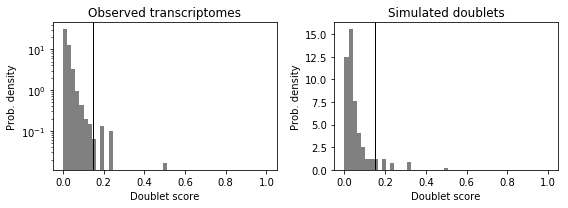

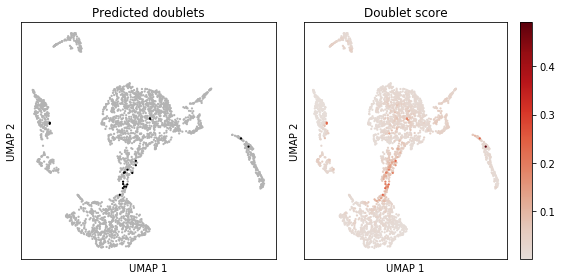

In [124]:
rep1 = run_scrublet('../output/scrnaseq-wf/scrnaseq_samples/testis1_force/outs/filtered_gene_bc_matrices_h5.h5', 'rep1', threshold=.15)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.28
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 5.8%
Overall doublet rate:
	Expected   = 2.3%
	Estimated  = 2.9%
Elapsed time: 2.2 seconds
Detected doublet rate = 1.1%
Estimated detectable doublet fraction = 22.1%
Overall doublet rate:
	Expected   = 2.3%
	Estimated  = 5.0%
Found 33 doublets.


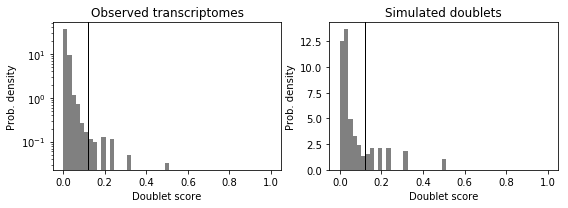

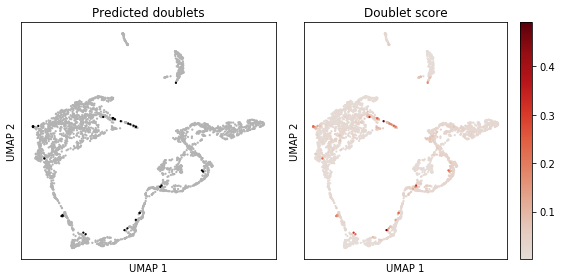

In [125]:
rep2 = run_scrublet('../output/scrnaseq-wf/scrnaseq_samples/testis2_force/outs/filtered_gene_bc_matrices_h5.h5', 'rep2', threshold=.12)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.66
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 6.1%
	Estimated  = 37.5%
Elapsed time: 5.5 seconds
Detected doublet rate = 1.9%
Estimated detectable doublet fraction = 20.3%
Overall doublet rate:
	Expected   = 6.1%
	Estimated  = 9.2%
Found 150 doublets.


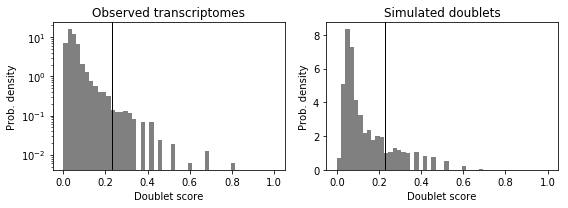

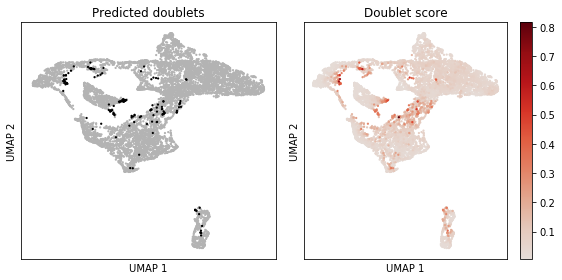

In [126]:
rep3 = run_scrublet('../output/scrnaseq-wf/scrnaseq_samples/testis3_force/outs/filtered_gene_bc_matrices_h5.h5', 'rep3', threshold=.23)

In [147]:
def read_list(fname):
    with open(fname) as fh:
        return fh.read().strip().split('\n')

In [201]:
def putative_dups(fname, rep):
    
    # Get all cells
    background = [f'{rep}_' + x.split('-')[0] for x in read_list(fname)]
    df = pd.DataFrame(index=background, columns=['scrublet', 'dupDetector', 'dupFinder']).fillna(False)

    # dup calls from different tools
    scrublet = read_list(f'../output/notebook/2018-11-01_testing_scrublet_{rep}.txt')
    df.loc[scrublet, 'scrublet'] = True

    dupFinder = read_list(f'../output/notebook/2018-10-30_testing_doubletFinder_{rep}.txt')
    df.loc[dupFinder, 'doubletFinder'] = True

    dupDetector = read_list(f'../output/notebook/2018-10-29_testing_doubletdetection_{rep}.txt')
    df.loc[dupDetector, 'doubletDetector'] = True

    _all = df[df.sum(axis=1) == 3].index.tolist()
    _most = df[df.sum(axis=1) == 2].index.tolist()
    _single = df[df.sum(axis=1) == 1].index.tolist()
    
    print(f'{len(_all)} cells were duplicates with all three methods.')
    print(f'{len(_most)} cells were duplicates in two of three methods.')
    print(f'{len(_single)} cells were duplicates in one of three methods.')
    
    with open('../output/notebook/2018-11-01_probable_doublet_rep1.txt', 'w') as fh:
        _dat = [*_all, *_most]
        fh.write('\n'.join(_dat))
        
    with open('../output/notebook/2018-11-01_putative_doublet_rep1.txt', 'w') as fh:
        _dat = [*_all, *_most, *_single]
        fh.write('\n'.join(_dat))

In [202]:
putative_dups('../output/scrnaseq-wf/scrnaseq_samples/testis1_force/outs/filtered_gene_bc_matrices/dm6.16/barcodes.tsv', 'rep1')

3 cells were duplicates with all three methods.
49 cells were duplicates in two of three methods.
129 cells were duplicates in one of three methods.


In [203]:
putative_dups('../output/scrnaseq-wf/scrnaseq_samples/testis2_force/outs/filtered_gene_bc_matrices/dm6.16/barcodes.tsv', 'rep2')

15 cells were duplicates with all three methods.
52 cells were duplicates in two of three methods.
115 cells were duplicates in one of three methods.


In [204]:
putative_dups('../output/scrnaseq-wf/scrnaseq_samples/testis3_force/outs/filtered_gene_bc_matrices/dm6.16/barcodes.tsv', 'rep3')

50 cells were duplicates with all three methods.
148 cells were duplicates in two of three methods.
942 cells were duplicates in one of three methods.
